In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from yellowbrick.model_selection import validation_curve 

In [2]:
target_set = pd.read_csv("data_test.csv", sep=",")
train_set = pd.read_csv("data_train.csv")

In [114]:
df = pd.concat([target_set, train_set])

## EDA

In [3]:
target_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,2,226802,2,7,0,9,3,1,0,0,0,40,0,0
1,38,2,89814,1,9,1,8,1,0,0,0,0,50,0,0
2,28,4,336951,6,12,1,12,1,0,0,0,0,40,0,1
3,44,2,160323,5,10,1,9,1,1,0,7688,0,40,0,1
4,18,5,103497,5,10,0,11,3,0,1,0,0,30,0,0


In [4]:
train_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0,77516,0,13,0,0,0,0,0,2174,0,40,0,0
1,50,1,83311,0,13,1,1,1,0,0,0,0,13,0,0
2,38,2,215646,1,9,2,2,0,0,0,0,0,40,0,0
3,53,2,234721,2,7,1,2,1,1,0,0,0,40,0,0
4,28,2,338409,0,13,1,3,2,1,1,0,0,40,1,0


In [5]:
train_set.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [6]:
train_set.shape,target_set.shape

((32561, 15), (16281, 15))

In [7]:
target_set['income'].value_counts()

0    12435
1     3846
Name: income, dtype: int64

## FUNCTIONS

#### CHECK IF ANY NULL VALUES

In [8]:
def print_column_na_count(df, column):
    print("null count column", column, df[column].isnull().sum())
    
print_column_na_count(train_set, 'education')

null count column education 0


#### MAKE A CONFUSION MATRIX

In [23]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues', ##Basic color is blue/ u can change it during the function call
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## ONE HOT ENCODING

In [96]:
#list of columns we want to One Hot Encode
ohe_list = ['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country']

#create new df with one hot encoded columns
df_train = pd.get_dummies(train_set, columns = ohe_list)
df_test = df = pd.get_dummies(target_set, columns = ohe_list)


In [97]:
#As there is no native-country41 in the test set we create one filled with '0'
df_test['native-country41']=0

In [98]:
#We check if the shapes are identical
df_test.shape,df_train.shape

((16281, 124), (32561, 124))

## MODEL EVALUATION - OG Data

In [13]:
#We split the data into a training and test set

X_train = train_set.drop('income', axis = 1)
y_train = train_set['income']
X_test =  target_set.drop('income', axis = 1)
y_test = target_set['income']

In [14]:
#We make sure it's the same size

X_test.shape,y_test.shape

((16281, 14), (16281,))

### Baseline Accuracy OG DATA

In [15]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Instantiate rf
rf = RandomForestClassifier(n_estimators=100)

TEST ACCURACY SCORE 85.40015969535041
TRAIN ACCURACY SCORE 99.99692884125182


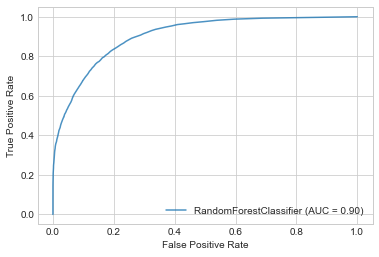

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281



In [16]:
from sklearn.metrics import plot_roc_curve

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('TEST ACCURACY SCORE',accuracy_score(y_test, y_pred)*100)
y_train_pre = rf.predict(X_train)
print('TRAIN ACCURACY SCORE',accuracy_score(y_train_pre, y_train)*100)
ax = plt.gca()
rf_disp = plot_roc_curve(rf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()
print(classification_report(y_test,y_pred))

### CONFUSION MATRIX

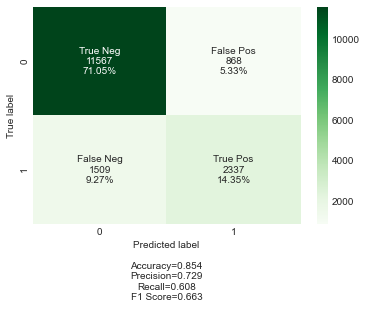

In [24]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(rf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Greens')

### CROSS VALIDATION SCORES

In [25]:
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.84801965 0.85902948 0.85411548 0.84981572 0.86025799 0.85165848
 0.86332924 0.85902948 0.86547912 0.85657248]
Mean: 0.8567307119272118
Standard Deviation: 0.0054715370412424975


### Validation Curve

In [ ]:
from yellowbrick.model_selection import validation_curve 
# Plot the validation curve
## Made in Pycharm because of packages/environment troubles
print(validation_curve(rf, X, y, param_name="max_depth", n_jobs=-1,
      param_range=np.arange(1, 11), cv=10, scoring="accuracy"))

## IMPORTANCE FEATURES

<AxesSubplot:xlabel='feature'>

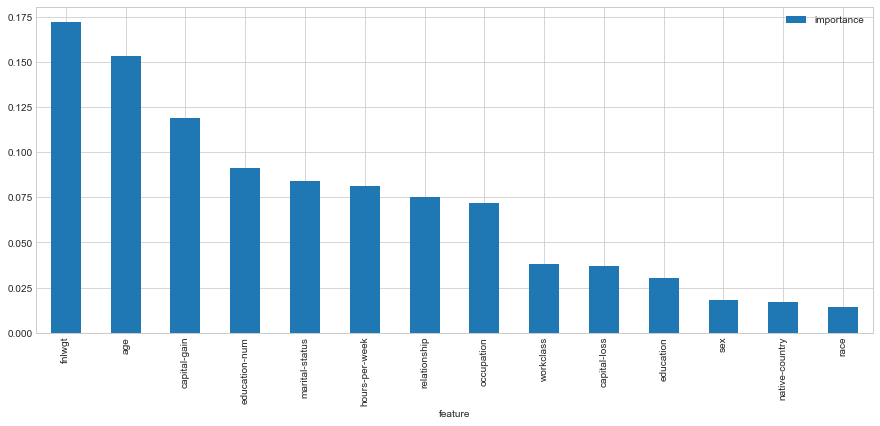

In [37]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances1 = importances.sort_values('importance',ascending=False).set_index('feature')
importances1.plot(kind='bar',figsize=(15,6))

### Build Random Forest Model with hyperparameters with GridSearchCV -1 n_jobs

Parameters

In [76]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 7]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# The function to measure the quality of a split
criterion = ['gini', 'entropy']


Create the param grid

In [77]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'criterion' : criterion,
             }
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 7], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [78]:
rfc_model = RandomForestClassifier()

In [79]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rfc_model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)

In [80]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [81]:
rf_Grid.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 48}

In [82]:
print (f'Train Accuracy  : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy  : {rf_Grid.score(X_test,y_test):.3f}')

Train Accuracy  : 0.860
Test Accuracy  : 0.857


### CROSS VALIDATION SCORE

In [ ]:
scores = cross_val_score(rf_Grid, X_train, y_train, cv=4, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

### Without -1 n_jobs

In [83]:
# Number of trees in random forest
n_estimators2 = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features2 = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth2 = [2,4]
# Minimum number of samples required to split a node
min_samples_split2 = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf2 = [1, 2]
# Method of selecting samples for training each tree
bootstrap2 = [True, False]

In [84]:
param_grid2 = {'n_estimators': n_estimators2,
               'max_features': max_features2,
               'max_depth': max_depth2,
               'min_samples_split': min_samples_split2,
               'min_samples_leaf': min_samples_leaf2,
               'bootstrap': bootstrap2}
print(param_grid2)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [85]:
rf_model2 = RandomForestClassifier()

In [86]:
from sklearn.model_selection import GridSearchCV
rf_grid2 = GridSearchCV(estimator = rf_model2, param_grid = param_grid2, cv = 10, verbose=2, n_jobs = 4)

In [87]:
rf_grid2.fit(X_train, y_train)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 3200 out of 3200 | elapsed:  6.5min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [88]:
rf_grid2.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 56}

In [91]:
print (f'Train Accuracy  : {rf_grid2.score(X_train,y_train):.3f}')
print (f'Test Accuracy  : {rf_grid2.score(X_test,y_test):.3f}')

Train Accuracy  : 0.847
Test Accuracy  : 0.846


### Cross Validation Score

In [ ]:
scores = cross_val_score(rf_grid2, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 3200 out of 3200 | elapsed:  6.3min finished


Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 202 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 405 tasks      | elapsed:   35.3s
[Parallel(n_jobs=4)]: Done 688 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1053 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 1498 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 2025 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 2632 tasks      | elapsed:  5.0min


### With RandomizedSearchCv

In [99]:
from sklearn.model_selection import RandomizedSearchCV
rf_randomgrid = RandomizedSearchCV(estimator = rfc_model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = -1)


In [100]:
rf_randomgrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.8s finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 6, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 7],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [101]:
rf_randomgrid.best_params_

{'n_estimators': 56,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'entropy',
 'bootstrap': False}

In [102]:
print (f'Train Accuracy  : {rf_randomgrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy  : {rf_randomgrid.score(X_test,y_test):.3f}')

Train Accuracy  : 0.859
Test Accuracy  : 0.856


### Validation Strategy 
Use the parameters from the Grid & Randomsearch Cv

In [103]:
rf_rscv = RandomForestClassifier(n_estimators=48,min_samples_split = 10,min_samples_leaf = 1, max_features ='auto',max_depth = 8, criterion = 'gini', bootstrap = True)


TEST ACCURACY SCORE 85.65198697868681
TRAIN ACCURACY SCORE 85.86652744080342


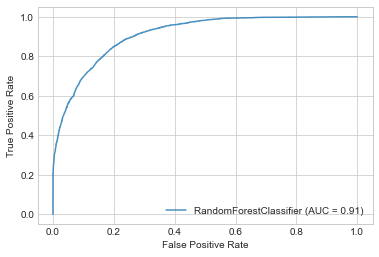

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     12435
           1       0.79      0.53      0.64      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.74      0.77     16281
weighted avg       0.85      0.86      0.85     16281



In [104]:
rf_rscv.fit(X_train, y_train)
y_pred = rf_rscv.predict(X_test)
print('TEST ACCURACY SCORE',accuracy_score(y_test, y_pred)*100)
y_train_pre = rf_rscv.predict(X_train)
print('TRAIN ACCURACY SCORE',accuracy_score(y_train_pre, y_train)*100)
ax = plt.gca()
rf_disp = plot_roc_curve(rf_rscv, X_test, y_test, ax=ax, alpha=0.8)
plt.show()
print(classification_report(y_test,y_pred))

### Confusion Matrix & Cross Val Scores

In [105]:
rf_rscv_matrix = confusion_matrix(y_test, y_pred)

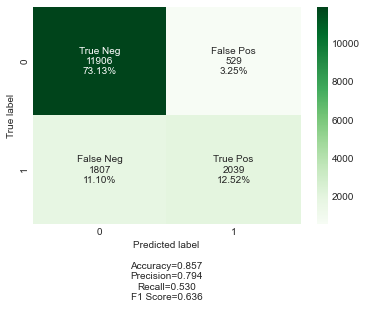

In [106]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(rf_rscv_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Greens')

### --------------------------------------------------------------------

### FIRST ATTEMPTS

## LOW PARAMETERS

In [95]:
clf=RandomForestClassifier()
kf=KFold(n_splits=3)
max_features=np.array([1,2,3,4,5])
n_estimators=np.array([10,25,50])
min_samples_leaf=np.array([10,25,50])
criterion = ['gini', 'entropy']
#max_depth = np.array([1,2,4,8,10])
param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf,criterion = criterion)
grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf)
gres=grid.fit(X_train,y_train)
print("Best",(gres.best_score_)*100)
print("params",gres.best_params_)

Best 86.2995729661281
params {'criterion': 'entropy', 'max_features': 4, 'min_samples_leaf': 10, 'n_estimators': 50}


## MID PARAMETERS

In [99]:
clf=RandomForestClassifier()
kf=KFold(n_splits=3)
max_features=np.array([1,2,3,4,5,6,7,8,9,10])
n_estimators=np.array([1,5,10,20,25])
min_samples_leaf=np.array([1,5,7,10])
criterion = ['gini', 'entropy']
#max_depth = np.array([1,2,4,8,10])
param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf,criterion = criterion)
grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf)
gres=grid.fit(X_train,y_train)
print("Best",(gres.best_score_)*100)
print("params",gres.best_params_)

Best 86.28728644465097
params {'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 7, 'n_estimators': 20}


## High Parameters

In [100]:
clf=RandomForestClassifier()
kf=KFold(n_splits=3)
max_features=np.array([1,2,3,4,5,6,7,8,9,10])
n_estimators=np.array([10,12,12,14,15,16,17,18,19,20])
min_samples_leaf=np.array([1,2,3,4,5,6,7])
criterion = ['gini', 'entropy']
#max_depth = np.array([1,2,4,8,10])
param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf,criterion = criterion)
grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf)
gres=grid.fit(X_train,y_train)
print("Best",(gres.best_score_)*100)
print("params",gres.best_params_)

Best 86.30571028451402
params {'criterion': 'gini', 'max_features': 3, 'min_samples_leaf': 7, 'n_estimators': 12}


### --------------------------------------------------------------------

## MODEL EVALUATION - OHE OG DATA

### Baseline Accuracy One Hot Encoded Data

In [70]:
X_train_o = df_train.drop('income', axis = 1)
y_train_o = df_train['income']
X_test_o =  df_test.drop('income', axis = 1)
y_test_o = df_test['income']

In [71]:
X_train_o.shape,y_train_o.shape,X_test_o.shape, y_test_o.shape

((32561, 123), (32561,), (16281, 123), (16281,))

In [72]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Instantiate rf
rfc = RandomForestClassifier(n_estimators=100)

TEST ACCURACY SCORE 85.0316319636386
TRAIN ACCURACY SCORE 99.9938576825036


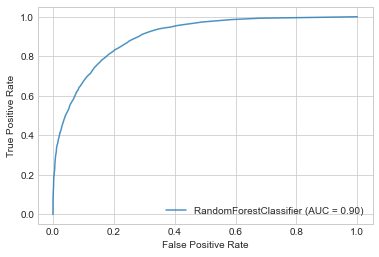

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12435
           1       0.72      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.77      0.78     16281
weighted avg       0.84      0.85      0.85     16281



In [73]:
rfc.fit(X_train_o, y_train_o)
y_pred_o = rfc.predict(X_test_o)
print('TEST ACCURACY SCORE',accuracy_score(y_test_o, y_pred_o)*100)
y_train_pre_o = rfc.predict(X_train_o)
print('TRAIN ACCURACY SCORE',accuracy_score(y_train_pre_o, y_train_o)*100)
ax = plt.gca()
rf_disp = plot_roc_curve(rfc, X_test_o, y_test_o, ax=ax, alpha=0.8)
plt.show()
print(classification_report(y_test_o,y_pred_o))

### CONFUSION MATRIX

In [74]:
# Generate the confusion matrix and classification report
rfo_matrix = confusion_matrix(y_test_o, y_pred_o)

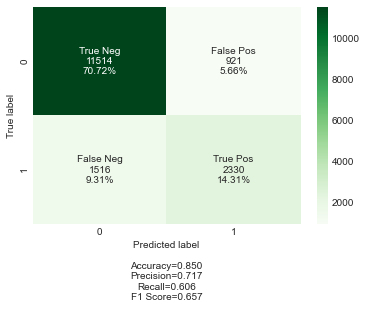

In [75]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(rfo_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Greens')

### Grid Search & RandomSearchCv

In [107]:
# Number of trees in random forest
n_estimators_o = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features_o = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth_o = [2,4]
# Minimum number of samples required to split a node
min_samples_split_o = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf_o = [1, 2]
# Method of selecting samples for training each tree
bootstrap_o = [True, False]

In [108]:
param_grid_o = {'n_estimators': n_estimators_o,
               'max_features': max_features_o,
               'max_depth': max_depth_o,
               'min_samples_split': min_samples_split_o,
               'min_samples_leaf': min_samples_leaf_o,
               'bootstrap': bootstrap_o}
print(param_grid_o)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [109]:
rf_model_o = RandomForestClassifier()

In [110]:
rf_grid_o = GridSearchCV(estimator = rf_model_o, param_grid = param_grid2, cv = 10, verbose=2, n_jobs = -1)

In [111]:
rf_grid_o.fit(X_train, y_train)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  6.6min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [112]:
rf_grid_o.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 56}

In [113]:
print (f'Train Accuracy  : {rf_grid_o.score(X_train,y_train):.3f}')
print (f'Test Accuracy  : {rf_grid_o.score(X_test,y_test):.3f}')

Train Accuracy  : 0.835
Test Accuracy  : 0.834


### --------------------------------------------------------------------

## FIRST ATTEMPTS

### Low parameters

In [63]:
clf=RandomForestClassifier()
kf=KFold(n_splits=3)
max_features=np.array([1,2,3,4,5])
n_estimators=np.array([10,25,50])
min_samples_leaf=np.array([10,25,50])
#max_depth = np.array([1,2,4,8,10])
param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf)
grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf)
gres=grid.fit(X_train_o,y_train_o)
print("Best",(gres.best_score_)*100)
print("params",gres.best_params_)

Best 84.68720811199272
params {'max_features': 5, 'min_samples_leaf': 10, 'n_estimators': 50}


### Mid parameters

In [64]:
clf=RandomForestClassifier()
kf=KFold(n_splits=3)
max_features=np.array([5,6,7,8,9,10])
n_estimators=np.array([50,60,70,80,90])
min_samples_leaf=np.array([50, 60, 70, 80])
#max_depth = np.array([1,2,4,8,10])
param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf)
grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf)
gres=grid.fit(X_train_o,y_train_o)
print("Best",(gres.best_score_)*100)
print("params",gres.best_params_)

Best 84.94826075629635
params {'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 90}


### High Parameters

In [65]:
clf=RandomForestClassifier()
kf=KFold(n_splits=3)
max_features=np.array([10,15,20,30])
n_estimators=np.array([90,100,110,120,130,140,150])
min_samples_leaf=np.array([1,5,8,10])
#max_depth = np.array([1,2,4,8,10])
param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf)
grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf)
gres=grid.fit(X_train_o,y_train_o)
print("Best",(gres.best_score_)*100)
print("params",gres.best_params_)

Best 86.43776916770497
params {'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 110}


In [66]:
clf=RandomForestClassifier()
kf=KFold(n_splits=3)
max_features=np.array([17, 18, 19, 20])
n_estimators=np.array([110,115,118,120])
min_samples_leaf=np.array([2,3,4,5])
#max_depth = np.array([1,2,4,8,10])
param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf)
grid=GridSearchCV(estimator=clf,param_grid=param_grid,cv=kf,verbose = 2)
gres=grid.fit(X_train_o,y_train_o)
print("Best",(gres.best_score_)*100)
print("params",gres.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_features=17, min_samples_leaf=2, n_estimators=110 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=17, min_samples_leaf=2, n_estimators=110, total=   3.6s
[CV] max_features=17, min_samples_leaf=2, n_estimators=110 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  max_features=17, min_samples_leaf=2, n_estimators=110, total=   3.7s
[CV] max_features=17, min_samples_leaf=2, n_estimators=110 ...........
[CV]  max_features=17, min_samples_leaf=2, n_estimators=110, total=   3.7s
[CV] max_features=17, min_samples_leaf=2, n_estimators=115 ...........
[CV]  max_features=17, min_samples_leaf=2, n_estimators=115, total=   3.7s
[CV] max_features=17, min_samples_leaf=2, n_estimators=115 ...........
[CV]  max_features=17, min_samples_leaf=2, n_estimators=115, total=   3.7s
[CV] max_features=17, min_samples_leaf=2, n_estimators=115 ...........
[CV]  max_features=17, min_samples_leaf=2, n_estimators=115, total=   3.7s
[CV] max_features=17, min_samples_leaf=2, n_estimators=118 ...........
[CV]  max_features=17, min_samples_leaf=2, n_estimators=118, total=   4.0s
[CV] max_features=17, min_samples_leaf=2, n_estimators=118 ...........
[CV]  max_features=17, min_samples_leaf=2, n_estimators=118, total=   3.8s
[CV] max_features=17, min_samples_leaf=2, n_estim

[CV]  max_features=18, min_samples_leaf=2, n_estimators=120, total=   4.0s
[CV] max_features=18, min_samples_leaf=2, n_estimators=120 ...........
[CV]  max_features=18, min_samples_leaf=2, n_estimators=120, total=   4.1s
[CV] max_features=18, min_samples_leaf=3, n_estimators=110 ...........
[CV]  max_features=18, min_samples_leaf=3, n_estimators=110, total=   3.5s
[CV] max_features=18, min_samples_leaf=3, n_estimators=110 ...........
[CV]  max_features=18, min_samples_leaf=3, n_estimators=110, total=   3.6s
[CV] max_features=18, min_samples_leaf=3, n_estimators=110 ...........
[CV]  max_features=18, min_samples_leaf=3, n_estimators=110, total=   3.5s
[CV] max_features=18, min_samples_leaf=3, n_estimators=115 ...........
[CV]  max_features=18, min_samples_leaf=3, n_estimators=115, total=   3.6s
[CV] max_features=18, min_samples_leaf=3, n_estimators=115 ...........
[CV]  max_features=18, min_samples_leaf=3, n_estimators=115, total=   3.6s
[CV] max_features=18, min_samples_leaf=3, n_estim

[CV]  max_features=19, min_samples_leaf=3, n_estimators=118, total=   4.0s
[CV] max_features=19, min_samples_leaf=3, n_estimators=118 ...........
[CV]  max_features=19, min_samples_leaf=3, n_estimators=118, total=   3.9s
[CV] max_features=19, min_samples_leaf=3, n_estimators=120 ...........
[CV]  max_features=19, min_samples_leaf=3, n_estimators=120, total=   3.9s
[CV] max_features=19, min_samples_leaf=3, n_estimators=120 ...........
[CV]  max_features=19, min_samples_leaf=3, n_estimators=120, total=   3.9s
[CV] max_features=19, min_samples_leaf=3, n_estimators=120 ...........
[CV]  max_features=19, min_samples_leaf=3, n_estimators=120, total=   4.0s
[CV] max_features=19, min_samples_leaf=4, n_estimators=110 ...........
[CV]  max_features=19, min_samples_leaf=4, n_estimators=110, total=   3.5s
[CV] max_features=19, min_samples_leaf=4, n_estimators=110 ...........
[CV]  max_features=19, min_samples_leaf=4, n_estimators=110, total=   3.5s
[CV] max_features=19, min_samples_leaf=4, n_estim

[CV]  max_features=20, min_samples_leaf=4, n_estimators=115, total=   3.9s
[CV] max_features=20, min_samples_leaf=4, n_estimators=115 ...........
[CV]  max_features=20, min_samples_leaf=4, n_estimators=115, total=   3.8s
[CV] max_features=20, min_samples_leaf=4, n_estimators=118 ...........
[CV]  max_features=20, min_samples_leaf=4, n_estimators=118, total=   3.9s
[CV] max_features=20, min_samples_leaf=4, n_estimators=118 ...........
[CV]  max_features=20, min_samples_leaf=4, n_estimators=118, total=   3.9s
[CV] max_features=20, min_samples_leaf=4, n_estimators=118 ...........
[CV]  max_features=20, min_samples_leaf=4, n_estimators=118, total=   3.9s
[CV] max_features=20, min_samples_leaf=4, n_estimators=120 ...........
[CV]  max_features=20, min_samples_leaf=4, n_estimators=120, total=   3.9s
[CV] max_features=20, min_samples_leaf=4, n_estimators=120 ...........
[CV]  max_features=20, min_samples_leaf=4, n_estimators=120, total=   4.0s
[CV] max_features=20, min_samples_leaf=4, n_estim

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 12.0min finished


Best 86.42548717373462
params {'max_features': 17, 'min_samples_leaf': 4, 'n_estimators': 115}


### --------------------------------------------------------------------